In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, dataset, transform=None, is_train=True, download=True):
        self.dataset = datasets.MNIST(
            root='./data', train=is_train, download=download, transform=transform
        )
        self.transform = transform
        self.is_train = is_train
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        """
        Get the anchor image at the given index, as well as a positive and a negative image
        :param idx: 
        :return: 
        """
        positive = None
        negative = None
        anchor, anchor_label = self.dataset[idx]
        if self.is_train:
            # Find a positive image
            positive_label = anchor_label
            positive_list = torch.where(self.dataset.targets == positive_label)[0]
            positive_idx = np.random.choice(positive_list)
            positive, _ = self.dataset[positive_idx]
            
            # Find a negative image
            negative_label = (anchor_label + np.random.randint(1, 10)) % 10
            negative_list = torch.where(self.dataset.targets == negative_label)[0]
            negative_idx = np.random.choice(negative_list)
            negative, _ = self.dataset[negative_idx]

            return anchor, positive, negative, anchor_label
        else:
            return anchor, anchor_label

In [4]:
# Load the MNIST dataset
train_dataset = MNISTDataset(
    dataset=datasets.MNIST, transform=transform, is_train=True, download=True
)
test_dataset = MNISTDataset(
    dataset=datasets.MNIST, transform=transform, is_train=False, download=True
)
# Create the train and test loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

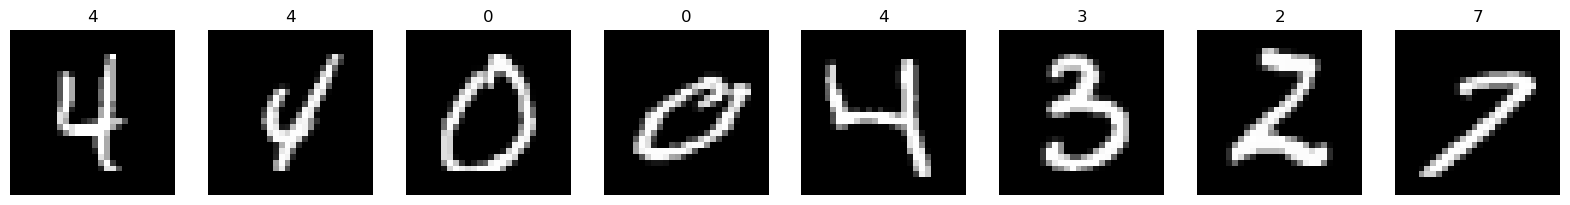

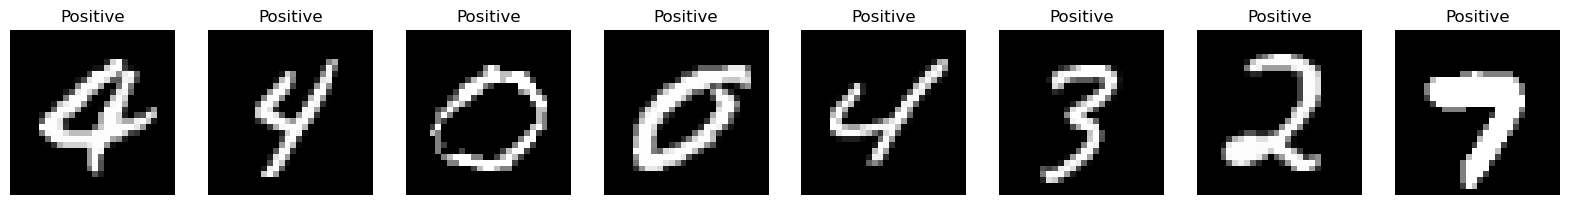

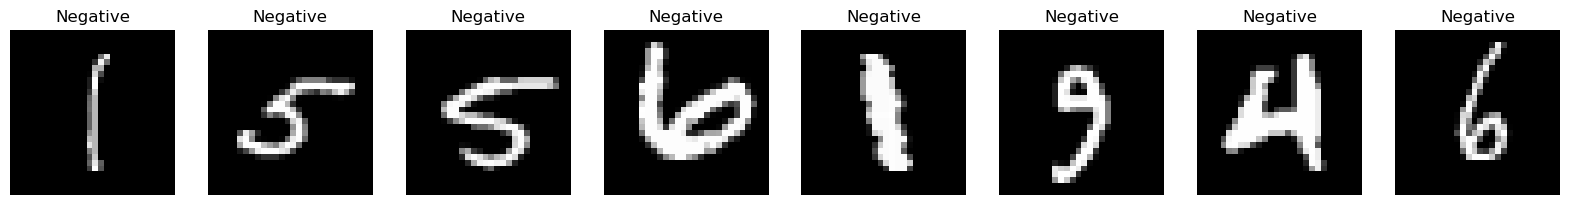

In [5]:
# Plot the images
def plot_images(images, labels=None, n=8):
    fig, ax = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        ax[i].imshow(images[i][0], cmap='gray')
        if labels is not None:
            ax[i].set_title(labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i])
        ax[i].axis('off')
    plt.show()

# Plot the images
anchor, positive, negative, labels = next(iter(train_loader))
plot_images(anchor, labels)
plot_images(positive, ['Positive'] * len(positive))
plot_images(negative, ['Negative'] * len(negative))

# Deep Metric Learning

In [6]:
# Define the model (CNN)
class Net(nn.Module):
    """
    A network that maps an image to an embedding (descriptor) with global pooling
    """
    def __init__(self, use_max=True, dim=512):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # Use either max or average pooling
        self.pool = nn.AdaptiveMaxPool2d((1, 1)) if use_max else nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x, eps=1e-6):
        x = self.conv(x)
        x = self.pool(x)
        x = F.normalize(x, p=2, dim=1, eps=eps)
        x = x.view(x.size(0), -1)
        return x

In [7]:
# Define the loss function (Triplet loss)
class TripletLoss(nn.Module):
    """
    Triplet loss
    """
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        d_pos = F.pairwise_distance(anchor, positive, p=2)
        d_neg = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(d_pos - d_neg + self.margin)
        return loss.mean()

In [8]:
from tqdm import tqdm

In [9]:
# train the model
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps') # if MacOS
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: mps


In [10]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = TripletLoss(margin=0.1)

In [11]:
# Define the training loop
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for anchor, positive, negative, label in tqdm(train_loader, total=len(train_loader), desc='Training'):
        optimizer.zero_grad()
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        anchor = model(anchor)
        positive = model(positive)
        negative = model(negative)
        
        loss = criterion(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [12]:
def test(model, test_loader):
    """
    Compute accuracy on the test set
    model: network
    test_loader: test_loader loading images and labels in batches
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, total=len(test_loader), desc='Testing'):
            data = data.to(device)
            output = model(data)
            embeddings.append(output)
            labels.append(target)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    # Compute pairwise distances
    distance_matrix = torch.cdist(embeddings, embeddings, p=2)
    # Sort distances and see if the label of the top-ranked image is correct
    prec = np.zeros(len(distance_matrix))
    for i in range(len(distance_matrix)):
        idx = torch.argsort(distance_matrix[i])[1]  # skip 1st image - is the query itself
        prec[i] = ((labels[idx] == labels[i]) * 1.0).mean().item()
    return prec.mean()

In [13]:
best_accuracy = 0
for epoch in range(2):
    loss = train(model, train_loader, optimizer, criterion, device)
    print(f'Epoch {epoch + 1}, Loss: {loss}')
    # Test the model
    accuracy = test(model, test_loader)
    print(f'Accuracy: {accuracy}')
    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model improved at epoch {epoch + 1}. Saving the model...')

Training:   6%|▌         | 56/938 [00:03<00:56, 15.53it/s]


KeyboardInterrupt: 

In [15]:
# load the model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [14]:
# Compute the accuracy on the test set
accuracy = test(model, test_loader)
print(f'Accuracy: {accuracy}')

Testing: 100%|██████████| 157/157 [00:00<00:00, 212.72it/s]


KeyboardInterrupt: 

In [16]:
# predict embeddings
model.eval()
embeddings = []
labels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, total=len(test_loader), desc='Predicting embeddings'):
        data = data.to(device)
        output = model(data)
        embeddings.append(output)
        labels.append(target)
embeddings = torch.cat(embeddings).cpu()
labels = torch.cat(labels).cpu()

Predicting embeddings: 100%|██████████| 157/157 [00:00<00:00, 212.63it/s]


In [17]:
from sklearn.manifold import TSNE

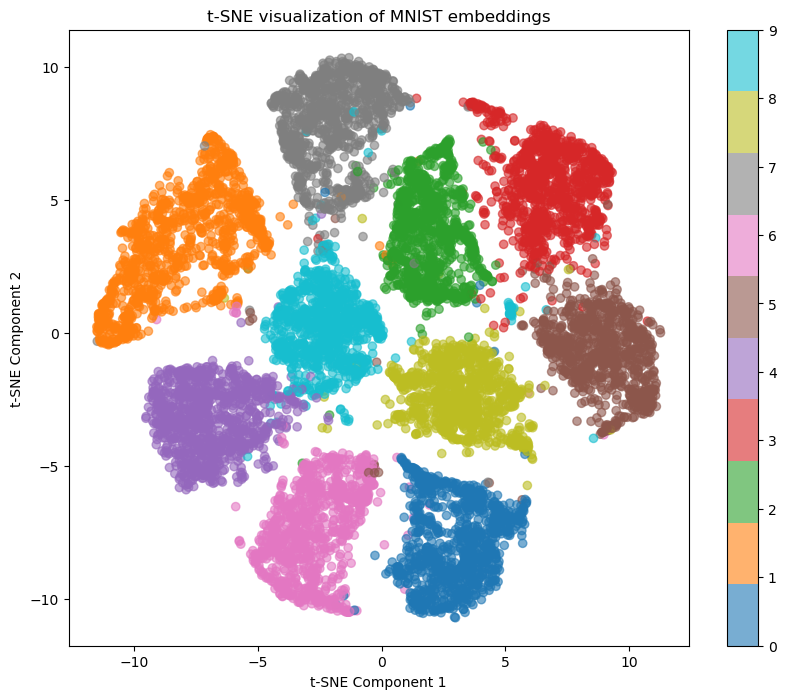

In [19]:
# Use t-SNE to reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE visualization of MNIST embeddings')
plt.show()